<a href="https://colab.research.google.com/github/dkalenov/youtube-meditation-project/blob/main/Youtube_meditation_channel_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case

The customer is going to launch her own YouTube channel on meditation and yoga classes aimed at a Russian-speaking audience. The goal is to collect data about competitors on YouTube and establish global trends in this area.


**Tasks:**
- Collecting and processing of data from YouTube, Google Trends and Yandex Wordstat;
- Data analysis;
- Identification of competitors (views, likes, comments, average video length, date and time of publications, dynamics of channel development);
- Identify the most popular tags for videos;
- Set the most frequently used words, phrases, phrases in the comments;
- Identify related areas in which similar content can be produced;
- Build a clear visualization.

## Youtube data extraction



To get your API use the link: https://console.cloud.google.com/cloud-resource-manager

In [ ]:
from googleapiclient.discovery import build
import re
import pandas as pd

api_key = 'YOUR API KEY'
youtube = build('youtube', 'v3', developerKey=api_key)

In [ ]:
def get_youtube_data(query, max_results=50, page_token=None):
    """Retrieves data about videos that match the search query"""
    request = youtube.search().list(
        q=query,
        part='id',
        type='video',
        order='viewCount',
        maxResults=max_results,
        pageToken=page_token
    )
    response = request.execute()

    videos = []
    channels = []
    for item in response['items']:
        video_id = item['id']['videoId']
        video_response = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=video_id
        ).execute()

        snippet = video_response['items'][0]['snippet']
        statistics = video_response['items'][0]['statistics']
        content_details = video_response['items'][0]['contentDetails']


        video_data = {
            'video_id': video_id,
            'title': snippet['title'],
            'channel_id': snippet['channelId'],
            'views': int(statistics.get('viewCount', 0)),
            'duration': content_details['duration'],
            'published_at': snippet['publishedAt'],
            'description': snippet.get('description', ''),
            'tags': snippet.get('tags', []),
            'category_id': snippet['categoryId'],
            'like_count': int(statistics.get('likeCount', 0)),
            'comment_count': int(statistics.get('commentCount', 0)),
            'url': f"https://www.youtube.com/watch?v={video_id}"
        }
        videos.append(video_data)


        channel_response = youtube.channels().list(
            part='snippet,statistics',
            id=snippet['channelId']
        ).execute()

        channel_snippet = channel_response['items'][0]['snippet']
        channel_statistics = channel_response['items'][0]['statistics']

        channel_data = {
            'channel_id': snippet['channelId'],
            'channel_title': channel_snippet['title'],
            'channel_description': channel_snippet.get('description', ''),
            'subscribers': int(channel_statistics.get('subscriberCount', 0)),
            'total_videos': int(channel_statistics.get('videoCount', 0)),
            'total_views': int(channel_statistics.get('viewCount', 0))
        }
        channels.append(channel_data)

    if 'nextPageToken' in response:
        next_page_token = response['nextPageToken']
        more_videos, more_channels = get_youtube_data(query, max_results, next_page_token)
        videos.extend(more_videos)
        channels.extend(more_channels)

    return videos, channels

In [ ]:
query = 'медитация'
meditation_videos, meditation_channels = get_youtube_data(query)

df_videos = pd.DataFrame(meditation_videos)
df_channels = pd.DataFrame(meditation_channels)

df_videos.head()
df_channels.head()

In [ ]:
def get_comments(video_id, max_results=50):
    """Receives comments on the video"""
    comments = []
    page_token = None

    while True:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=max_results,
            pageToken=page_token
        )
        response = request.execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                'video_id': video_id,
                'comment_id': item['id'],
                'author': comment['authorDisplayName'],
                'text': comment['textOriginal'],
                'like_count': int(comment.get('likeCount', 0)),
                'published_at': comment['publishedAt']
            }
            comments.append(comment_data)

        page_token = response.get('nextPageToken')
        if not page_token:
            break

    return comments

In [ ]:
video_id = df_videos.iloc[0]['video_id'] # Receives comments on the first video
comments = get_comments(video_id)
df_comments = pd.DataFrame(comments)

df_comments.head()

In [ ]:
df_comments

,video_id,comment_id,author,text,like_count,published_at
0,1ZYbU82GVz4,Ugwn5InAMg4umRQbG_14AaABAg,@cjc132,I've been putting this on every night for 3 ye...,1565,2024-04-11T02:56:40Z
1,1ZYbU82GVz4,UgxqfJNl7e-Kpe0knX94AaABAg,@betzysosa5872,Dios es Amor❤ Les deseo a todos!!! todo lo me...,1,2024-06-26T04:18:10Z
2,1ZYbU82GVz4,UgyAgwOgvqRGDZtBsol4AaABAg,@Jaywolf271,I'm drowning in debt. Talking to my girlfriend...,1,2024-06-25T22:28:22Z
3,1ZYbU82GVz4,Ugz_uyGKdUozP_LMiLF4AaABAg,@anittakristiansen8423,❤❤❤❤❤❤❤❤❤❤❤,0,2024-06-25T17:51:46Z
4,1ZYbU82GVz4,UgxTy5BJMEKCwWflBkp4AaABAg,@relaxingmusicmariam,"To anybody who's reading this, I pray that wha...",1,2024-06-25T15:16:05Z
...,...,...,...,...,...,...
60695,1ZYbU82GVz4,Ugz0hzEwTK2Js8IJ3D94AaABAg,@jesseshue5012,Make another one,0,2018-08-23T01:19:59Z
60696,1ZYbU82GVz4,UgzJble9xR5X3l2mSeR4AaABAg,@jesseshue5012,I listen to it all night and every day,0,2018-08-23T01:19:35Z
60697,1ZYbU82GVz4,Ugwbz2wY8AaIzpIPU3p4AaABAg,@jj_thesimp2394,Britain,0,2018-08-23T00:29:06Z
60698,1ZYbU82GVz4,Ugy-9g2qvm7jX9xbglx4AaABAg,@dijstelbloem123,wants to find music to sleep. Ends up watching...,0,2018-08-22T23:18:48Z


In [ ]:
df_videos

,video_id,title,channel_id,views,duration,published_at,description,tags,category_id,like_count,comment_count,duration_seconds,url
0,1ZYbU82GVz4,"Flying: Deep Relaxing Music for Sleep, Meditat...",UCjzHeG1KWoonmf9d5KBvSiw,426831830,PT3H22S,2016-07-03T17:09:48Z,Relaxing sleep music for deep sleeping and str...,"[relax, relaxing music, soothing relaxation, p...",10,2540571,136404,10822.0,https://www.youtube.com/watch?v=1ZYbU82GVz4
1,BiqlZZddZEo,Dance of Life: Relaxing Celtic Music for Medit...,UCjzHeG1KWoonmf9d5KBvSiw,63017196,PT3H4M47S,2016-09-17T18:00:01Z,"Relaxing fantasy music, ""Dance of Life"" by Ped...","[calm, calm music, calming, calming music, cel...",10,574439,22722,11087.0,https://www.youtube.com/watch?v=BiqlZZddZEo
2,2Z9fey85b-c,Художник Геннадий Улыбин. Медитация. Живопись....,UCMUrG2HLKbs_t_TuJaEawUA,49485792,PT3M,2016-09-27T23:11:27Z,"В этом видео я показываю мою картину ""Медитаци...","[искусство, живопись, Геннадий Улыбин, совреме...",27,29058,434,180.0,https://www.youtube.com/watch?v=2Z9fey85b-c
3,lh4JdZTJe7k,12 Hours of Relaxing Sleep Music for Stress Re...,UCjzHeG1KWoonmf9d5KBvSiw,41883029,PT11H58M9S,2020-01-27T12:11:20Z,12 hours of relaxing sleep music for stress re...,"[calm, calm music, calming, calming music, cel...",10,178615,12092,43089.0,https://www.youtube.com/watch?v=lh4JdZTJe7k
4,qxyVCjp48S4,Headspace | Meditation | Training the Monkey Mind,UC3JhfsgFPLSLNEROQCdj-GQ,37331254,PT1M8S,2018-03-30T23:02:34Z,"When you first close your eyes to meditate, yo...","[Headspace, meditation, mindfulness, Andy Pudd...",26,7179,162,68.0,https://www.youtube.com/watch?v=qxyVCjp48S4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,m518SkMjsb0,Послание Архангела 🙏 #просветленный #angel #пр...,UCuCb4UGQ5nVqf5c-KKLPDLA,1214,PT31S,2024-06-18T19:11:33Z,,[],22,0,14,31.0,https://www.youtube.com/watch?v=m518SkMjsb0
594,BNx71APXrwU,Peaceful Sound Meditation 7 | Relaxing Music f...,UC2QJFEXKq39KLh5vSxqzGWw,1222,PT11H13M42S,2024-06-23T11:00:22Z,#zenmusic #meditation #yoga #stressrelief #rel...,"[Positive Energy, positive energy meditation m...",10,18,2,40422.0,https://www.youtube.com/watch?v=BNx71APXrwU
595,nIq2LGtVLEI,Вечерняя Медитация Очищения от Разрушительных ...,UCSI3RM2B-D93DT2uVGW_nNQ,7813,PT24M54S,2024-06-25T18:35:38Z,🙏Техника выполнения очищающей медитации: https...,"[медитация, лучшая медитация для женщин, лучша...",22,1640,159,1494.0,https://www.youtube.com/watch?v=nIq2LGtVLEI
596,AtsopfkTEVM,В жизни обязательно должны быть паузы 🤫 #йогао...,UCrNhAqGEd6xLJ2ZBZXhr-2w,2122,PT16S,2024-06-22T07:19:59Z,,[],17,76,3,16.0,https://www.youtube.com/watch?v=AtsopfkTEVM


In [ ]:
df_channels

,channel_id,channel_title,channel_description,subscribers,total_videos,total_views
0,UCjzHeG1KWoonmf9d5KBvSiw,Soothing Relaxation,Soothing Relaxation is a passion project by th...,11000000,559,4148160158
1,UCjzHeG1KWoonmf9d5KBvSiw,Soothing Relaxation,Soothing Relaxation is a passion project by th...,11000000,559,4148160158
2,UCMUrG2HLKbs_t_TuJaEawUA,Геннадий Улыбин,Добро пожаловать на мой канал. Я художник Генн...,161000,343,96094896
3,UCjzHeG1KWoonmf9d5KBvSiw,Soothing Relaxation,Soothing Relaxation is a passion project by th...,11000000,559,4148160158
4,UC3JhfsgFPLSLNEROQCdj-GQ,Headspace,Your guide to being kind to your mind. \n\nThr...,714000,376,793512130
...,...,...,...,...,...,...
593,UCuCb4UGQ5nVqf5c-KKLPDLA,Послание АНГЕЛА 💖 | Яровой. Канал Моей Жизни,🥰ПОДДЕРЖАТЬ НАС: 2200 7010 6592 3390. (Илдар. ...,1120,31,55810
594,UC2QJFEXKq39KLh5vSxqzGWw,Positive Energy,Hi❤️\n\nPositive Energy is a YouTube channel w...,2240,72,45114
595,UCSI3RM2B-D93DT2uVGW_nNQ,Вселена Мастер,Вселена Мастер - Общественный Деятель и Лидер ...,556000,986,95775503
596,UCrNhAqGEd6xLJ2ZBZXhr-2w,YOGA SPACE,"🤍YOGA SPACE🤍\n\n Пространство - где тело, душа...",78,33,11051


In [ ]:
df_channels.to_csv('channels.csv', index=False, encoding='utf-8-sig')
df_videos.to_csv('videos.csv', index=False, encoding='utf-8-sig')
df_comments.to_csv('comments.csv', index=False, encoding='utf-8-sig')

In [ ]:
all_comments = []

for video_id in df_videos['video_id']:
    comments = get_comments(video_id)
    all_comments.extend(comments)

df_all_comments = pd.DataFrame(all_comments)

df_all_comments

In [ ]:
df_all_comments = pd.DataFrame(all_comments)

df_all_comments

,video_id,comment_id,author,text,like_count,published_at
0,1ZYbU82GVz4,Ugwn5InAMg4umRQbG_14AaABAg,@cjc132,I've been putting this on every night for 3 ye...,1565,2024-04-11T02:56:40Z
1,1ZYbU82GVz4,UgxqfJNl7e-Kpe0knX94AaABAg,@betzysosa5872,Dios es Amor❤ Les deseo a todos!!! todo lo me...,1,2024-06-26T04:18:10Z
2,1ZYbU82GVz4,UgyAgwOgvqRGDZtBsol4AaABAg,@Jaywolf271,I'm drowning in debt. Talking to my girlfriend...,1,2024-06-25T22:28:22Z
3,1ZYbU82GVz4,Ugz_uyGKdUozP_LMiLF4AaABAg,@anittakristiansen8423,❤❤❤❤❤❤❤❤❤❤❤,0,2024-06-25T17:51:46Z
4,1ZYbU82GVz4,UgxTy5BJMEKCwWflBkp4AaABAg,@relaxingmusicmariam,"To anybody who's reading this, I pray that wha...",1,2024-06-25T15:16:05Z
...,...,...,...,...,...,...
135934,cZk0SXlDpYY,Ugya-K4r_2tlW_r0Rxp4AaABAg,@markgraf888,Самая красивая мантра из слышанных. Спасибо\n,0,2013-09-06T12:14:51Z
135935,cZk0SXlDpYY,UgynV5II45fuIMFUpmB4AaABAg,@user-ct4ju4ey9o,Боже!!!!! Душа улетает!!!!!!,0,2013-09-02T11:17:04Z
135936,cZk0SXlDpYY,Ugz9pqlROdiOzOPLLNN4AaABAg,@user-po4gy2fm9r,Видеоряд очень красивый. Спасибо. :),0,2013-08-30T10:03:52Z
135937,cZk0SXlDpYY,UgwXtYHeMvOIKuuOW_B4AaABAg,@domoctroy2306,Мантра и вправду творит чудеса! Божественная Л...,34,2013-07-28T20:00:15Z


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=43c2e07d98f6c46437a897f5c91bbff7450566fd545b8cd4bb31501507e0008e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


### Data preproccessing

In [15]:
#data = df_videos.copy()
data = pd.read_csv('videos.csv')
df = data.copy()
df

,title,channel,views,duration,published_at,description,tags,category_id,like_count,dislike_count,comment_count,duration_seconds,url
0,"Flying: Deep Relaxing Music for Sleep, Meditat...",Soothing Relaxation,426793805,PT3H22S,2016-07-03T17:09:48Z,Relaxing sleep music for deep sleeping and str...,"['relax', 'relaxing music', 'soothing relaxati...",10,2540504,0,136392,10822.0,https://www.youtube.com/watch?v=1ZYbU82GVz4
1,Dance of Life: Relaxing Celtic Music for Medit...,Soothing Relaxation,63013225,PT3H4M47S,2016-09-17T18:00:01Z,"Relaxing fantasy music, ""Dance of Life"" by Ped...","['calm', 'calm music', 'calming', 'calming mus...",10,574428,0,22720,11087.0,https://www.youtube.com/watch?v=BiqlZZddZEo
2,12 Hours of Relaxing Sleep Music for Stress Re...,Soothing Relaxation,41869090,PT11H58M9S,2020-01-27T12:11:20Z,12 hours of relaxing sleep music for stress re...,"['calm', 'calm music', 'calming', 'calming mus...",10,178578,0,12090,43089.0,https://www.youtube.com/watch?v=lh4JdZTJe7k
3,Headspace | Meditation | Training the Monkey Mind,Headspace,37331185,PT1M8S,2018-03-30T23:02:34Z,"When you first close your eyes to meditate, yo...","['Headspace', 'meditation', 'mindfulness', 'An...",26,7180,0,162,68.0,https://www.youtube.com/watch?v=qxyVCjp48S4
4,Isha Kriya: A Guided Meditation For Health And...,Sadhguru,28990380,PT19M29S,2019-06-04T09:30:00Z,Isha Kriya is a guided 15-minute meditation fo...,"['quick meditation', 'meditation', 'morning me...",26,268194,0,10902,1169.0,https://www.youtube.com/watch?v=EwQkfoKxRvo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,Сильная аффирмация. ЗАВЕТНАЯ МЕЧТА 🌟 #аффирмац...,Антон Морозов,1067,PT20S,2024-06-24T19:00:07Z,✨🌟 Сильная аффирмация для достижения заветной ...,"['психология', 'психология человека', 'это нуж...",22,424,0,218,20.0,https://www.youtube.com/watch?v=aWp-7oo-BX8
593,КАК БЫСТРО ВОЙТИ В ТРАНС #дыхание #транс #меди...,ДЫХАНИЕ I СОСТОЯНИЕ I YAN.G,4507,PT38S,2024-06-22T07:21:30Z,NaN,[],22,446,0,7,38.0,https://www.youtube.com/watch?v=L7aoHt0rgSo
594,Peaceful Sound Meditation 7 | Relaxing Music f...,Positive Energy,1191,PT11H13M42S,2024-06-23T11:00:22Z,#zenmusic #meditation #yoga #stressrelief #rel...,"['Positive Energy', 'positive energy meditatio...",10,18,0,1,40422.0,https://www.youtube.com/watch?v=BNx71APXrwU
595,Что вы поняли из видео? Как нужно? #осознаннос...,Психология жизни для вас,853,PT51S,2024-06-25T00:30:54Z,Что вы поняли из видео? Как нужно? #желания #п...,[],22,26,0,1,51.0,https://www.youtube.com/watch?v=RL0SMjJw6GY


### Top tags

Top tags

In [31]:
import pandas as pd
from collections import Counter


# Extract all tags into one list, clearing them of unnecessary characters
all_tags = []
for tags_str in df['tags']:
    tags = tags_str.strip('[]').split(', ')
    all_tags.extend([tag.strip("'") for tag in tags])


tag_counts = Counter(all_tags)


sorted_tag_counts = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

In [32]:
print("Top 15 tags:")
for tag, count in sorted_tag_counts[:15]:
    print(f"{tag}: {count}")

Top 15 tags:
медитация: 246
медитация перед сном: 155
: 91
лучшая медитация: 82
гипноз: 71
медитация для сна: 70
медитация для начинающих: 68
meditation: 67
медитации: 63
исцеляющие медитации: 62
музыка для медитации: 59
музыка для сна: 49
медитация очищения от негатива: 47
meditation music: 41
лечебная музыка: 40


In [30]:
df_top_tags = pd.DataFrame(sorted_tag_counts, columns=['tag', 'count'])
df_top_tags

,tag,count
0,медитация,246
1,медитация перед сном,155
2,,91
3,лучшая медитация,82
4,гипноз,71
...,...,...
5034,inner peace music,1
5035,руна,1
5036,гебо,1
5037,значение,1


In [ ]:
df_top_tags.to_csv('top_tags.csv', index=False, encoding='utf-8-sig')

### Publishing time

In [24]:
import pandas as pd
from collections import Counter

# Assume your DataFrame is called 'df'

# Convert the published_at column to datetime and set the timezone to Asia/Ho_Chi_Minh
df['published_at'] = pd.to_datetime(df['published_at'].dt.tz_convert('Asia/Ho_Chi_Minh'))

# Determine the most popular day of the week
popular_weekday = df['published_at'].dt.day_name().mode()[0]
print(f"Most popular day of the week: {popular_weekday}")

# Determine the most popular hour
popular_hour = df['published_at'].dt.hour.mode()[0]
print(f"Most popular hour: {popular_hour}")

# Determine the most popular minute
popular_minute = df['published_at'].dt.minute.mode()[0]
print(f"Most popular minute: {popular_minute}")

# Determine the most popular second
popular_second = df['published_at'].dt.second.mode()[0]
print(f"Most popular second: {popular_second}")

Most popular day of the week: Friday
Most popular hour: 23
Most popular minute: 0
Most popular second: 11


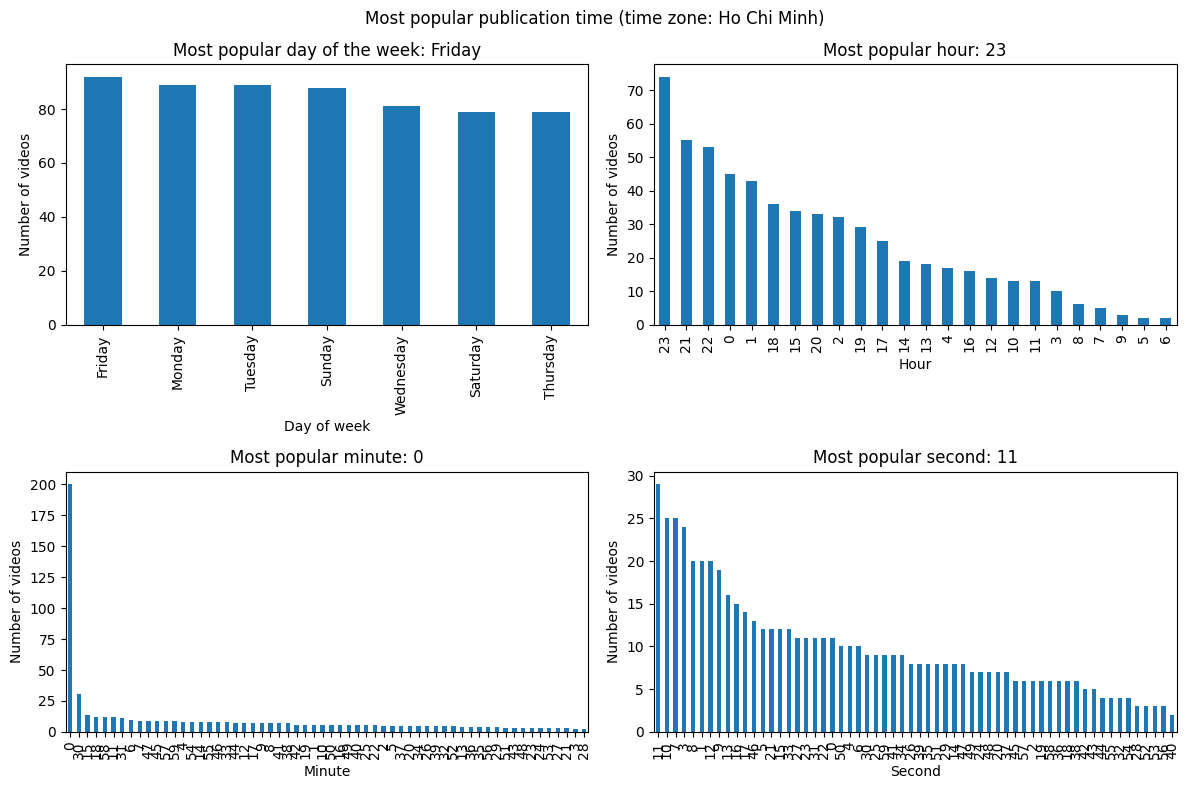

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz

# Determine the most popular day of the week
popular_weekday = df['published_at'].dt.day_name().mode().values[0]
weekday_counts = df['published_at'].dt.day_name().value_counts()

# Determine the most popular hour
popular_hour = df['published_at'].dt.hour.mode().values[0]
hour_counts = df['published_at'].dt.hour.value_counts()

# Determine the most popular minute
popular_minute = df['published_at'].dt.minute.mode().values[0]
minute_counts = df['published_at'].dt.minute.value_counts()

# Determine the most popular second
popular_second = df['published_at'].dt.second.mode().values[0]
second_counts = df['published_at'].dt.second.value_counts()

# Plotting charts
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Day of the week
weekday_counts.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title(f'Most popular day of the week: {popular_weekday}')
axes[0,0].set_xlabel('Day of week')
axes[0,0].set_ylabel('Number of videos')

# Hour
hour_counts.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title(f'Most popular hour: {popular_hour}')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Number of videos')

# Minute
minute_counts.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title(f'Most popular minute: {popular_minute}')
axes[1,0].set_xlabel('Minute')
axes[1,0].set_ylabel('Number of videos')

# Second
second_counts.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title(f'Most popular second: {popular_second}')
axes[1,1].set_xlabel('Second')
axes[1,1].set_ylabel('Number of videos')

plt.suptitle(f'Most popular publication time (time zone: Ho Chi Minh)')
plt.tight_layout()
plt.show()

### Data Video

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   video_id          601 non-null    object 
 1   title             601 non-null    object 
 2   channel_id        601 non-null    object 
 3   views             601 non-null    int64  
 4   duration          601 non-null    object 
 5   published_at      601 non-null    object 
 6   description       601 non-null    object 
 7   tags              601 non-null    object 
 8   category_id       601 non-null    object 
 9   like_count        601 non-null    int64  
 10  comment_count     601 non-null    int64  
 11  duration_seconds  589 non-null    float64
 12  url               601 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 61.2+ KB


In [ ]:
import pandas as pd
from datetime import datetime
import pytz

# Create a time zone object for Hanoi, Vietnam
hanoi_tz = pytz.timezone('Asia/Ho_Chi_Minh')

# Convert 'published_at' to date and time format taking into account Hanoi time zone
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_convert(hanoi_tz)

# Add new columns
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month
df['day_of_week'] = df['published_at'].dt.day_name()
df['day'] = df['published_at'].dt.day
df['hour'] = df['published_at'].dt.hour
df['minutes'] = df['published_at'].dt.minute

# Check the updated dataframe
df.head()

,video_id,title,channel_id,views,duration,published_at,description,tags,category_id,like_count,comment_count,duration_seconds,url,year,month,day,hour,minutes
0,1ZYbU82GVz4,"Flying: Ambient Relaxing Music for Sleep, Medi...",UCjzHeG1KWoonmf9d5KBvSiw,426850865,PT3H22S,2016-07-04 00:09:48+07:00,Relaxing sleep music for deep sleeping and str...,"[relax, relaxing music, soothing relaxation, p...",10,2540616,136410,10822.0,https://www.youtube.com/watch?v=1ZYbU82GVz4,2016,7,4,0,9
1,BiqlZZddZEo,Dance of Life: Relaxing Celtic Music for Medit...,UCjzHeG1KWoonmf9d5KBvSiw,63020013,PT3H4M47S,2016-09-18 01:00:01+07:00,"Relaxing fantasy music, ""Dance of Life"" by Ped...","[calm, calm music, calming, calming music, cel...",10,574452,22723,11087.0,https://www.youtube.com/watch?v=BiqlZZddZEo,2016,9,18,1,0
2,T8yEdNx4dB0,Quiet Night: Deep Sleep Music with Black Scree...,UCjzHeG1KWoonmf9d5KBvSiw,62886734,PT3H5M46S,2019-02-17 17:20:37+07:00,"Deep sleep music (""Quiet Night"") that hopefull...","[sleep music, deep sleep, sleeping music, soot...",10,338339,10939,11146.0,https://www.youtube.com/watch?v=T8yEdNx4dB0,2019,2,17,17,20
3,lh4JdZTJe7k,12 Hours of Relaxing Sleep Music for Stress Re...,UCjzHeG1KWoonmf9d5KBvSiw,41891279,PT11H58M9S,2020-01-27 19:11:20+07:00,12 hours of relaxing sleep music for stress re...,"[calm, calm music, calming, calming music, cel...",10,178626,12092,43089.0,https://www.youtube.com/watch?v=lh4JdZTJe7k,2020,1,27,19,11
4,qxyVCjp48S4,Headspace | Meditation | Training the Monkey Mind,UC3JhfsgFPLSLNEROQCdj-GQ,37331287,PT1M8S,2018-03-31 06:02:34+07:00,"When you first close your eyes to meditate, yo...","[Headspace, meditation, mindfulness, Andy Pudd...",26,7180,162,68.0,https://www.youtube.com/watch?v=qxyVCjp48S4,2018,3,31,6,2


In [ ]:
import pandas as pd
import re

# Function for checking the presence of Russian words
def has_russian_words(text):
 russian_pattern = r'[a-zA-Z]'
 return bool(re.search(russian_pattern, str(text)))


df['has_russian'] = df['title'].apply(has_russian_words) | df['description'].apply(has_russian_words)

df_video_ru = df[df['has_russian']]
df_video_ru

,video_id,title,channel_id,views,duration,published_at,description,tags,category_id,like_count,comment_count,duration_seconds,url,year,month,day,hour,minutes,has_russian
7,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,6076,13482.0,https://www.youtube.com/watch?v=kndqIj8Qgok,2019,2,5,14,0,True
10,F-V6rgokQTw,Медитация - гипноз 🙏 Сильнейший сеанс для очищ...,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,PT50M12S,2017-12-27 16:59:33+07:00,Медитация - гипноз 🙏 Сильнейший сеанс для очис...,"[медитация перед сном, медитация для сна, гипн...",29,192528,7630,3012.0,https://www.youtube.com/watch?v=F-V6rgokQTw,2017,12,27,16,59,True
11,OHPNzxg9V68,Медитация Исцеление Нервной Системы | Восстано...,UCQ__rXROBpF6mKjCZ29ij9Q,14643225,PT48M,2017-10-10 23:40:36+07:00,Медитация Исцеление Нервной Системы | Восстано...,"[медитация, медитация перед сном, гипноз, меди...",10,173481,8725,2880.0,https://www.youtube.com/watch?v=OHPNzxg9V68,2017,10,10,23,40,True
12,cZk0SXlDpYY,Привлечение Любви в вашу жизнь. Мантра Любви и...,UCUlYdFMCbA0_aMT2W4DraDw,14552036,PT8M16S,2013-07-23 14:31:59+07:00,Регулярное прослушивание этой мантры может сот...,"[привлечение любви, мантра любви и нежности, г...",22,90220,5065,496.0,https://www.youtube.com/watch?v=cZk0SXlDpYY,2013,7,23,14,31,True
14,trbQx6CwCzw,"Нежная музыка, успокаивает нервную систему и р...",UCNS3dqFGBPhxHmOigehpBeg,13893545,P0D,2023-02-06 15:46:22+07:00,"Нежная музыка, успокаивает нервную систему и р...","[Музыка Для Массажа, музыка для медитации, Муз...",10,89972,0,NaN,https://www.youtube.com/watch?v=trbQx6CwCzw,2023,2,6,15,46,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,CwgxerxhLec,Джо Диспенза «1000 распахнутых сердец» Группов...,UCmtqU2EtSb1YoqV3Xz0LqfQ,1419,PT1H23M34S,2024-06-24 02:30:33+07:00,Наблюдайте за своими практиками медитации и от...,"[новая норма, медитация, йога, саморазвитие, и...",27,152,9,5014.0,https://www.youtube.com/watch?v=CwgxerxhLec,2024,6,24,2,30,True
596,AtsopfkTEVM,В жизни обязательно должны быть паузы 🤫 #йогао...,UCrNhAqGEd6xLJ2ZBZXhr-2w,2122,PT16S,2024-06-22 14:19:59+07:00,,[],17,76,3,16.0,https://www.youtube.com/watch?v=AtsopfkTEVM,2024,6,22,14,19,True
597,aWp-7oo-BX8,Сильная аффирмация. ЗАВЕТНАЯ МЕЧТА 🌟 #аффирмац...,UCCrflVh8dFa8QXp05DrZw3A,1939,PT20S,2024-06-25 02:00:07+07:00,✨🌟 Сильная аффирмация для достижения заветной ...,"[психология, психология человека, это нужно зн...",22,643,333,20.0,https://www.youtube.com/watch?v=aWp-7oo-BX8,2024,6,25,2,0,True
599,2-e8q1vmWPw,Позволение себе через ДРУГИХ людей | Сильнейша...,UC0wqxr_6mr7xO9rwDELbfUQ,77,PT14M3S,2024-06-26 20:56:36+07:00,РЕКОМЕНДАЦИИ:\nДля супер мощного эффекта реком...,[],22,7,3,843.0,https://www.youtube.com/watch?v=2-e8q1vmWPw,2024,6,26,20,56,True


In [ ]:
# Combine df_video_ru and df_channels using the 'channel_id' column
df_video_ru = pd.merge(df_video_ru, df_channels[['channel_id', 'channel_title']], on='channel_id', how='left')

df_video_ru.head()

,video_id,title,channel_id,views,duration,published_at,description,tags,category_id,like_count,...,top_tag_6_count,top_tag_7,top_tag_7_count,top_tag_8,top_tag_8_count,top_tag_9,top_tag_9_count,top_tag_10,top_tag_10_count,channel_title
0,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
1,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
2,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
3,F-V6rgokQTw,Медитация - гипноз 🙏 Сильнейший сеанс для очищ...,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,PT50M12S,2017-12-27 16:59:33+07:00,Медитация - гипноз 🙏 Сильнейший сеанс для очис...,"[медитация перед сном, медитация для сна, гипн...",29,192528,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,Елена Вальяк
4,F-V6rgokQTw,Медитация - гипноз 🙏 Сильнейший сеанс для очищ...,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,PT50M12S,2017-12-27 16:59:33+07:00,Медитация - гипноз 🙏 Сильнейший сеанс для очис...,"[медитация перед сном, медитация для сна, гипн...",29,192528,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,Елена Вальяк


In [ ]:
# Function to convert duration to seconds
def convert_duration_to_seconds(duration):
    match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration)
    if match:
        hours = int(match.group(1)[:-1]) if match.group(1) else 0
        minutes = int(match.group(2)[:-1]) if match.group(2) else 0
        seconds = int(match.group(3)[:-1]) if match.group(3) else 0
        return hours * 3600 + minutes * 60 + seconds
    else:
        return 0


df_video_ru['duration_seconds'] = df_video_ru['duration'].apply(convert_duration_to_seconds)
df_video_ru.head()

,video_id,title,channel_id,views,duration,published_at,description,tags,category_id,like_count,...,top_tag_6_count,top_tag_7,top_tag_7_count,top_tag_8,top_tag_8_count,top_tag_9,top_tag_9_count,top_tag_10,top_tag_10_count,channel_title
0,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
1,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
2,kndqIj8Qgok,Спокойная Музыка Для Медитации И Снятия Стрес...,UCVrUkS1grWtiUP7VRLbGLZA,18869022,PT3H44M42S,2019-02-05 14:00:02+07:00,★ 🎶Серия расслабляющей музыки DOZE OFF MEDUZA...,"[Музыка Для Массажа, музыка для медитации, Str...",22,153867,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,DOZE OFF MEDUZA / STAV IT SKY
3,F-V6rgokQTw,Медитация - гипноз 🙏 Сильнейший сеанс для очищ...,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,PT50M12S,2017-12-27 16:59:33+07:00,Медитация - гипноз 🙏 Сильнейший сеанс для очис...,"[медитация перед сном, медитация для сна, гипн...",29,192528,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,Елена Вальяк
4,F-V6rgokQTw,Медитация - гипноз 🙏 Сильнейший сеанс для очищ...,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,PT50M12S,2017-12-27 16:59:33+07:00,Медитация - гипноз 🙏 Сильнейший сеанс для очис...,"[медитация перед сном, медитация для сна, гипн...",29,192528,...,68,медитации,67,музыка для медитации,58,музыка для сна,45,саморазвитие,45,Елена Вальяк


In [ ]:
df_video_ru.info()

In [ ]:
df_video_ru.to_csv('video_ru.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_video_ru.to_csv('video_ru.csv', index=False, encoding='utf-8-sig')

In [ ]:
num_duplicates = df_channel.duplicated().sum()
num_duplicates

326

In [ ]:
df_channel = df_channel.drop_duplicates()

In [ ]:
df_channel

,channel_id,channel_title,channel_description,subscribers,total_videos,total_views
0,UCjzHeG1KWoonmf9d5KBvSiw,Soothing Relaxation,Soothing Relaxation is a passion project by th...,11000000,559,4148160158
4,UC3JhfsgFPLSLNEROQCdj-GQ,Headspace,Your guide to being kind to your mind. \n\nThr...,714000,377,793512130
5,UCcYzLCs3zrQIBVHYA1sK2sw,Sadhguru,Official YouTube Channel of Sadhguru\n\nConsi...,12000000,3517,1640246201
6,UCEMArgthHuEtX-04qL_8puQ,Goodful,"Goodful\nFeel better, be better, and do better...",1610000,962,243769056
7,UCVrUkS1grWtiUP7VRLbGLZA,DOZE OFF MEDUZA / STAV IT SKY,Hi Guys !! I Make Music For Relaxation And Med...,380000,93,118555476
...,...,...,...,...,...,...
595,UC2QJFEXKq39KLh5vSxqzGWw,Positive Energy,Hi❤️\n\nPositive Energy is a YouTube channel w...,2240,73,45114
596,UCrNhAqGEd6xLJ2ZBZXhr-2w,YOGA SPACE,"🤍YOGA SPACE🤍\n\n Пространство - где тело, душа...",78,33,11051
598,UCGxAZFGjDn-Z6gvbxW1VF7Q,The Sound of Inner Peace,"Hi ❤️️\n\nIf you are tired, stressed, or insom...",12200,261,2461110
599,UC0wqxr_6mr7xO9rwDELbfUQ,ANKHELINA 💎 СВОБОДНОЕ МЫШЛЕНИЕ,4 бесплатных подкаста о 💸. Ты поймёшь почему у...,1690,310,208184


In [ ]:
df_channel.to_csv('channels.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_channel.info()

In [ ]:
import pandas as pd



# Добавление столбца "день недели"
df_video_ru_tableau['day_of_week'] = pd.to_datetime(df_video_ru_tableau['published_at']).dt.day_name()

df_video_ru_tableau.head()

,video_id,channel_id,views,duration,published_at,category_id,like_count,comment_count,duration_seconds,year,month,day,hour,minutes,channel_title,day_of_week
0,kndqIj8Qgok,UCVrUkS1grWtiUP7VRLbGLZA,18869022,0 days 03:44:42,2019-02-05 14:00:02,22,153867,6076,13482,2019,2,5,14,0,DOZE OFF MEDUZA / STAV IT SKY,Tuesday
1,F-V6rgokQTw,UCgDyuvWoEK9sQD8MwZ1oWoQ,14805593,0 days 00:50:12,2017-12-27 16:59:33,29,192528,7630,3012,2017,12,27,16,59,Елена Вальяк,Wednesday
2,OHPNzxg9V68,UCQ__rXROBpF6mKjCZ29ij9Q,14643225,0 days 00:48:00,2017-10-10 23:40:36,10,173481,8725,2880,2017,10,10,23,40,Исцеляющие Медитации,Tuesday
3,cZk0SXlDpYY,UCUlYdFMCbA0_aMT2W4DraDw,14552036,0 days 00:08:16,2013-07-23 14:31:59,22,90220,5065,496,2013,7,23,14,31,Domoctroy,Tuesday
4,trbQx6CwCzw,UCNS3dqFGBPhxHmOigehpBeg,13893545,0 days 00:00:00,2023-02-06 15:46:22,10,89972,0,0,2023,2,6,15,46,Love YourSelf,Monday


In [ ]:
df_video_ru_tableau.to_csv('df_video_ru_tableau.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_channels_tableau.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 600
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   channel_id     275 non-null    object
 1   channel_title  275 non-null    object
 2   subscribers    275 non-null    int64 
 3   total_videos   275 non-null    int64 
 4   total_views    275 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.9+ KB


In [ ]:
df_video.to_csv('video_ru.csv', index=False, encoding='utf-8-sig')

## Google Trends

In [33]:
!pip install pytrends

In [34]:
from pytrends.request import TrendReq
import pandas as pd

# Establishing a connection to Google Trends
pytrends = TrendReq(hl='ru-RU', tz=360)

def get_trends_data(keywords, timeframe='today 12-m'):
    """
    Retrieves trend data for given keywords and time interval
    """
    pytrends.build_payload(keywords, cat=0, timeframe=timeframe, geo='', gprop='')
    data = pytrends.interest_over_time()
    return data

keywords = ['медитация', 'релаксация', 'осознанность']
trends_data = get_trends_data(keywords)

trends_data.to_csv('google_trends_data.csv', index=False, encoding='utf-8-sig')
print("Trend data has been successfully collected and saved to a CSV file.")

Trend data has been successfully collected and saved to a CSV file.
